Dataset obtenido de:
https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes

# Preprocesado

In [1]:
import numpy as np
import pandas as pd
import glob
from os.path import basename as bname
import datetime
import seaborn as sns
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive
from jax import random, vmap
# numpyro.set_platform("cpu")

/home/pedro/miniconda3/envs/only_numpyro/lib/python3.9/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/home/pedro/miniconda3/envs/only_numpyro/lib/python3.9/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


In [2]:
raw = pd.concat([pd.read_csv(g).assign(brand=bname(g)) for g in glob.glob("dataset/*csv")])
raw

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand,tax(£)
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,audi.csv,NaN
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,audi.csv,NaN
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,audi.csv,NaN
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,audi.csv,NaN
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,audi.csv,NaN
...,...,...,...,...,...,...,...,...,...,...,...
15152,Eos,2012,5990,Manual,74000,Diesel,125.0,58.9,2.0,vw.csv,NaN
15153,Fox,2008,1799,Manual,88102,Petrol,145.0,46.3,1.2,vw.csv,NaN
15154,Fox,2009,1590,Manual,70000,Petrol,200.0,42.0,1.4,vw.csv,NaN
15155,Fox,2006,1250,Manual,82704,Petrol,150.0,46.3,1.2,vw.csv,NaN


In [3]:
KM_PER_MILE = 1.60934
LITRES_PER_GALLON = 3.78541
MINIMAL_PRICE = 1000
MAX_LITRES_PER_100 = 100
MAX_KILOMETERS = 350_000
MAX_AGE = 35


def calculate_max_price(d: pd.DataFrame):
    max_group = d.groupby(["model"]).agg({"price": "max"}).reset_index()
    return d.merge(max_group, how="left", on="model", suffixes=("", "_max"))


dt = pd.concat([pd.read_csv(g).assign(brand=bname(g)) for g in glob.glob("dataset/*csv")])\
    .assign(kilometers=lambda x: x["mileage"] * KM_PER_MILE)\
    .assign(litres_per_100k=lambda x: 100.0 / (x["mpg"] * KM_PER_MILE / LITRES_PER_GALLON))\
    .assign(brand=lambda x: x.brand.str.replace(".csv", "", regex=False))\
    .assign(model=lambda x: x.brand + x.model)\
    .assign(age=lambda d: datetime.datetime.now().year - d["year"])\
    .assign(norm_km=lambda d: d["kilometers"] / MAX_KILOMETERS)\
    .assign(model_observation_id=lambda d: d.groupby(["model"]).cumcount())\
    .pipe(calculate_max_price)\
    .assign(norm_price=lambda d: d["price"] / d["price_max"])\
    .astype({c: "category" for c in ["model", "transmission", "brand", "fuelType"]})\
    .drop(["tax", "mpg", "tax(£)", "mileage"], axis=1)\
    .drop_duplicates(subset=["model", "year", "price", "kilometers"], keep='last')\
    .pipe(lambda d: d[d["price"] > MINIMAL_PRICE])\
    .pipe(lambda d: d[d["year"] < datetime.datetime.now().year + 1])\
    .pipe(lambda d: d[d["age"] < MAX_AGE])\
    .pipe(lambda d: d[d["kilometers"] < MAX_KILOMETERS])\

dt

,model,year,price,transmission,fuelType,engineSize,brand,kilometers,litres_per_100k,age,norm_km,model_observation_id,price_max,norm_price
0,audi A1,2017,12500,Manual,Petrol,1.4,audi,25322.96490,4.245759,4,0.072351,0,30950,0.403877
1,audi A6,2016,16500,Automatic,Diesel,2.0,audi,58262.93602,3.663786,5,0.166466,0,60000,0.275000
2,audi A1,2016,11000,Manual,Petrol,1.4,audi,48193.29564,4.245759,5,0.137695,1,30950,0.355412
3,audi A4,2017,16800,Automatic,Diesel,2.0,audi,41765.59168,3.495023,4,0.119330,0,52000,0.323077
4,audi A3,2019,17300,Manual,Petrol,1.0,audi,3215.46132,4.742239,2,0.009187,0,36990,0.467694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99182,vw Eos,2012,5990,Manual,Diesel,2.0,vw,119091.16000,3.993464,9,0.340260,6,12495,0.479392
99183,vw Fox,2008,1799,Manual,Petrol,1.2,vw,141786.07268,5.080239,13,0.405103,0,2295,0.783878
99184,vw Fox,2009,1590,Manual,Petrol,1.4,vw,112653.80000,5.600359,12,0.321868,1,2295,0.692810
99185,vw Fox,2006,1250,Manual,Petrol,1.2,vw,133098.85536,5.080239,15,0.380282,2,2295,0.544662


# Edad del coche o kilómetros

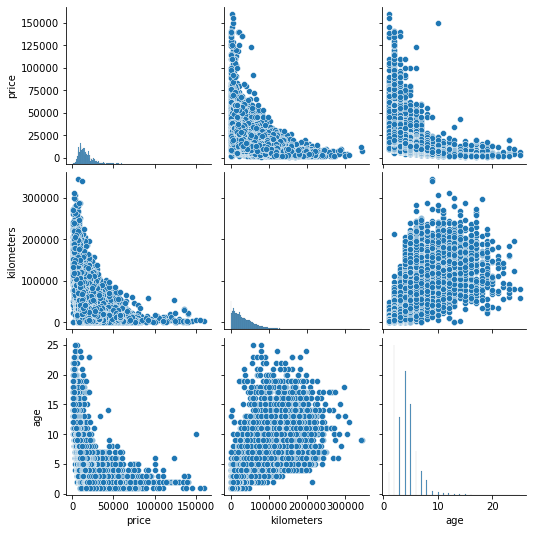

In [4]:
to_plot = dt[["price", "kilometers", "age"]].copy().reset_index(drop=True)

sns.pairplot(to_plot)

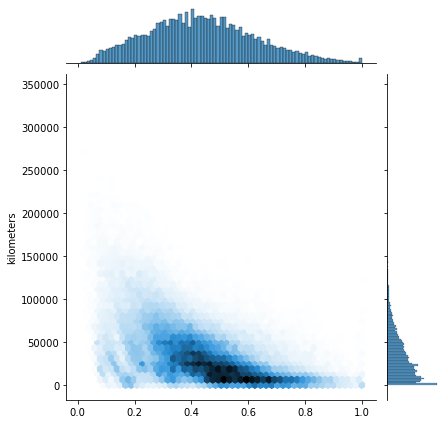

In [5]:
to_plot = dt[["price", "kilometers", "price_max"]].copy().reset_index(drop=True)
sns.jointplot(y=to_plot["kilometers"], x=to_plot["price"] / to_plot["price_max"], kind="hex")

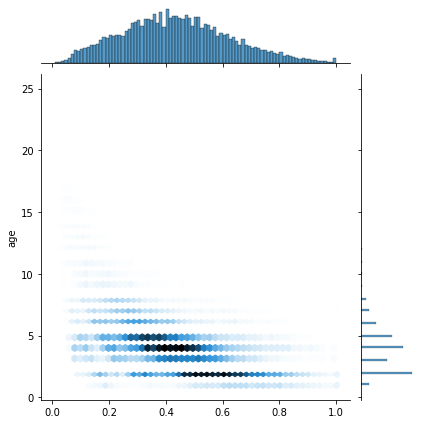

In [6]:
to_plot = dt[["price", "age", "price_max"]].copy().reset_index(drop=True)
sns.jointplot(x=to_plot["price"] / to_plot["price_max"], y=to_plot["age"], kind="hex")

# Buscamos una función similar

<AxesSubplot:>

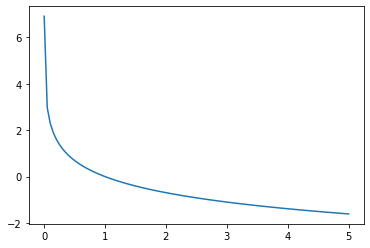

In [7]:
x = np.linspace(0.001, 5, 100)
y = - np.log(x)

sns.lineplot(x=x, y=y)

<AxesSubplot:>

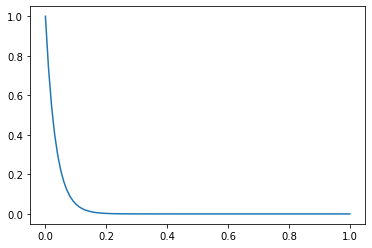

In [8]:
x = np.linspace(0, 1, 100)
y = np.exp(-x * 30.0) * 1.0 + 0.0

sns.lineplot(x=x, y=y)

# Jax

<AxesSubplot:>

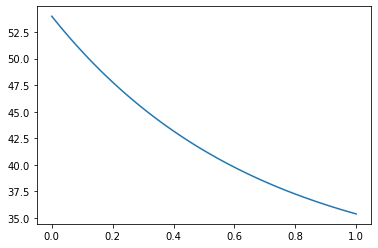

In [9]:
from typing import TypedDict
import jax.numpy as jnp
import jax


class KilometersCurveParams(TypedDict):
    base: float
    scale: float
    speed: float
    offset: float


@jax.jit
def model(values: float, params: KilometersCurveParams):
    """
    :param values: Kilometers of the car
    :param params: some params, lest think about it later
    :return: a number c such that max_price_model * c = price_with_this_kilometers
    """
    sp = params["speed"]
    sc = params["scale"]
    b = params["base"]
    of = params["offset"]
    return jnp.exp(-sp * (values + of)) * sc + jnp.maximum(b, 0.0)


sns.lineplot(x=x, y=model(x, KilometersCurveParams(base=30, scale=24, speed=1.5, offset=0.0)))

In [10]:
sample_x = 3.0
sample_params = {"base": 30.0, "scale": 24.0, "speed": 1.8, "offset": 0.0}

model_dx = jax.grad(model, argnums=0)
print(f"{model_dx(sample_x, sample_params)}")

-0.19511635601520538


In [11]:
model_dθ = jax.grad(model, argnums=1)
print(model_dθ(sample_x, sample_params))

{'base': DeviceArray(1., dtype=float32), 'offset': DeviceArray(-0.19511636, dtype=float32), 'scale': DeviceArray(0.00451658, dtype=float32), 'speed': DeviceArray(-0.32519394, dtype=float32)}


<AxesSubplot:>

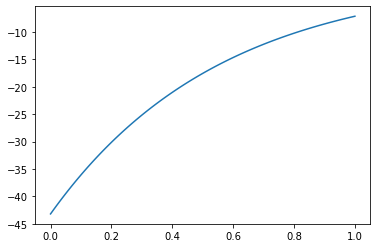

In [12]:
vectorized_derivative = jax.vmap(model_dx, in_axes=(0, None))

sns.lineplot(x=x, y=vectorized_derivative(x, sample_params))

# Primera aproximación

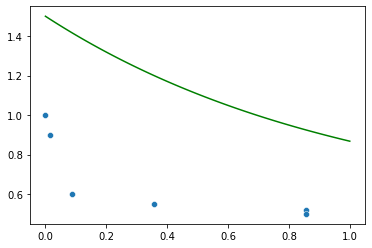

In [13]:
import matplotlib.pyplot as plt

sample_kilometers = jnp.array([0, 5_000, 30_000, 125_000, 300_000, 300_000]) / MAX_KILOMETERS
sample_real_price = jnp.array([1.0, 0.9, 0.6, 0.55, 0.52, 0.50])

sample_params = KilometersCurveParams(scale=1.0, base=0.5, speed=1.0, offset=0.0)
kilometers_line = jnp.linspace(0, 1, 100)
model_line = model(kilometers_line, params=sample_params)

fig, ax = plt.subplots(figsize=(6, 4))
p1 = sns.scatterplot(x=sample_kilometers, y=sample_real_price, ax=ax)
p2 = sns.lineplot(x=kilometers_line, y=model_line, color='g', ax=ax)

In [14]:
@jax.jit
def model_error(
        kilometers: jnp.array,
        real_price: jnp.array,
        model_params: KilometersCurveParams
):
    predicted_price = model(kilometers, model_params)
    absolute_error = jnp.abs(predicted_price - real_price)
    return jnp.sum(absolute_error)


model_error_dθ = jax.grad(model_error, argnums=2)

In [15]:
model_error_dθ(sample_kilometers, sample_real_price, sample_params)

{'base': DeviceArray(6., dtype=float32),
 'offset': DeviceArray(-4.4520903, dtype=float32, weak_type=True),
 'scale': DeviceArray(4.4520903, dtype=float32, weak_type=True),
 'speed': DeviceArray(-1.0701358, dtype=float32, weak_type=True)}

{'base': DeviceArray(0.3600019, dtype=float32), 'offset': DeviceArray(0.25525147, dtype=float32), 'scale': DeviceArray(0.7819017, dtype=float32), 'speed': DeviceArray(1.6336986, dtype=float32)}


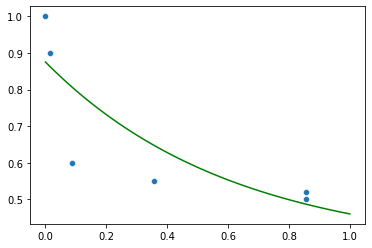

In [16]:
current_params = sample_params

for i in range(1000):
    step = 0.01
    derivative_value = model_error_dθ(sample_kilometers, sample_real_price, current_params)
    current_params = {
        "base": current_params["base"] - step * derivative_value["base"],
        "offset": current_params["offset"] - step * derivative_value["offset"],
        "scale": current_params["scale"] - step * derivative_value["scale"],
        "speed": current_params["speed"] - step * derivative_value["speed"]
    }

print(current_params)

model_line = model(kilometers_line, params=current_params)
fig, ax = plt.subplots(figsize=(6, 4))
p1 = sns.scatterplot(x=sample_kilometers, y=sample_real_price, ax=ax)
p2 = sns.lineplot(x=kilometers_line, y=model_line, color='g', ax=ax)

# Mejorando la optimización "a mano"

{'base': DeviceArray(0.49799997, dtype=float32), 'offset': DeviceArray(0.07977927, dtype=float32), 'scale': DeviceArray(0.84910655, dtype=float32), 'speed': DeviceArray(5.9326406, dtype=float32)}


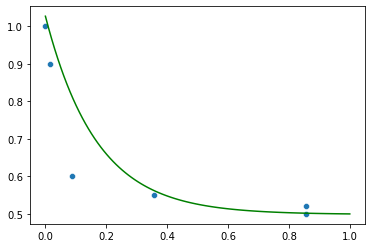

In [17]:
current_params = sample_params

for i in range(1000):
    step = 0.01
    derivative_value = model_error_dθ(sample_kilometers, sample_real_price, current_params)
    current_params = {
        "base": current_params["base"] - step * derivative_value["base"] * 0.1,
        "offset": current_params["offset"] - step * derivative_value["offset"],
        "scale": current_params["scale"] - step * derivative_value["scale"],
        "speed": current_params["speed"] - step * derivative_value["speed"] * 10.0
    }

print(current_params)

model_line = model(kilometers_line, params=current_params)
fig, ax = plt.subplots(figsize=(6, 4))
p1 = sns.scatterplot(x=sample_kilometers, y=sample_real_price, ax=ax)
p2 = sns.lineplot(x=kilometers_line, y=model_line, color='g', ax=ax)

# Entrenado con todos lo coches

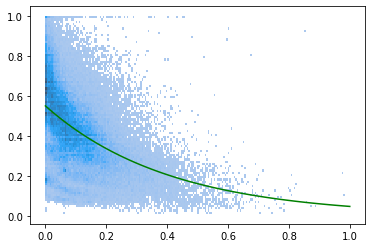

In [18]:
kms = jnp.array(dt["norm_km"].values)
prices = jnp.array(dt["norm_price"].values)
current_params = sample_params

@jax.jit
def manual_update(p):
    step = 0.01 / kms.shape[0]
    derivative_value = model_error_dθ(kms, prices, p)
    return {
        "base": p["base"] - step * derivative_value["base"] * 0.5,
        "offset": p["offset"] - step * derivative_value["offset"],
        "scale": p["scale"] - step * derivative_value["scale"],
        "speed": p["speed"] - step * derivative_value["speed"] * 2
    }


for i in range(10_000):
    current_params = manual_update(current_params)

model_line = model(kilometers_line, params=current_params)
fig, ax = plt.subplots(figsize=(6, 4))
p1 = sns.histplot(x=kms, y=prices, ax=ax)
p2 = sns.lineplot(x=kilometers_line, y=model_line, color='g', ax=ax)

# Mirando coches concretos

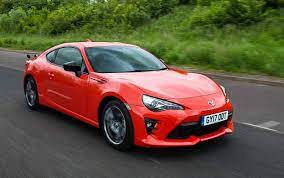

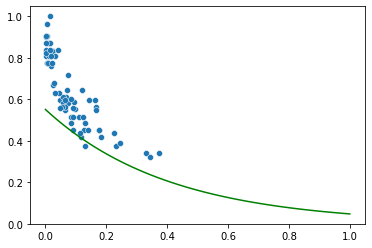

In [19]:
toyota_dt = dt[dt["model"] == "toyota GT86"]
kms = jnp.array(toyota_dt["norm_km"].values)
prices = jnp.array(toyota_dt["norm_price"].values)

model_line = model(kilometers_line, params=current_params)
fig, ax = plt.subplots(figsize=(6, 4))
p1 = sns.scatterplot(x=kms, y=prices, ax=ax)
p2 = sns.lineplot(x=kilometers_line, y=model_line, color='g', ax=ax)

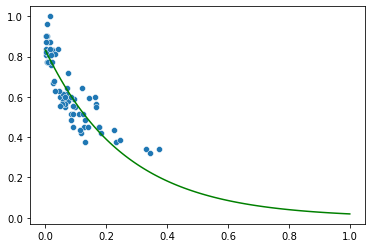

In [20]:
toyota_dt = dt[dt["model"] == "toyota GT86"]
kms = jnp.array(toyota_dt["norm_km"].values)
prices = jnp.array(toyota_dt["norm_price"].values)


@jax.jit
def manual_update(p, kms):
    step = 0.01 / kms.shape[0]
    derivative_value = model_error_dθ(kms, prices, p)
    return {
        "base": p["base"] - step * derivative_value["base"] * 0.1,
        "offset": p["offset"] - step * derivative_value["offset"],
        "scale": p["scale"] - step * derivative_value["scale"],
        "speed": p["speed"] - step * derivative_value["speed"] * 10.0
    }

for i in range(10_000):
    current_params = manual_update(current_params, kms)

model_line = model(kilometers_line, params=current_params)
fig, ax = plt.subplots(figsize=(6, 4))
p1 = sns.scatterplot(x=kms, y=prices, ax=ax)
p2 = sns.lineplot(x=kilometers_line, y=model_line, color='g', ax=ax)

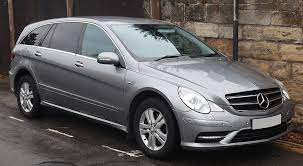

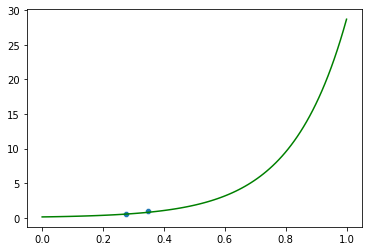

In [21]:
toyota_dt = dt[dt["model"] == "merc R Class"]
kms = jnp.array(toyota_dt["norm_km"].values)
prices = jnp.array(toyota_dt["norm_price"].values)

for i in range(10_000):
    current_params = manual_update(current_params, kms)

model_line = model(kilometers_line, params=current_params)
fig, ax = plt.subplots(figsize=(6, 4))
p1 = sns.scatterplot(x=kms, y=prices, ax=ax)
p2 = sns.lineplot(x=kilometers_line, y=model_line, color='g', ax=ax)

![rick](https://c.tenor.com/NhtFcGSWSAkAAAAC/republica-de-fifidonia-rick.gif "rick")

# Bienvenido a numpyro

In [22]:
def model_bayes(kilometers, prices=None):
    sampled_params = {
        "base": numpyro.sample("base", dist.HalfCauchy(0.3)),
        "offset": numpyro.sample("offset", dist.Normal(0, 1)),
        "scale": numpyro.sample("scale", dist.Normal(1, 0.2)),
        "speed": numpyro.sample("speed", dist.Normal(4.0, 3))
    }

    results = model(kilometers, sampled_params)

    σ = numpyro.sample("error_std", dist.HalfNormal(0.1))
    with numpyro.plate("independent_observations", kilometers.shape[0]):
        numpyro.sample("observations", dist.Normal(results, σ), prices)

    return results

In [23]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
kernel = NUTS(model_bayes)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=500, num_samples=num_samples)
mcmc.run(
    rng_key, kilometers=kms, prices=prices
)
mcmc.print_summary()
samples = mcmc.get_samples()

sample: 100%|██████████| 2500/2500 [00:02<00:00, 1036.80it/s, 3 steps of size 1.11e-01. acc. prob=0.82] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
       base      0.50      0.28      0.54      0.05      0.88    188.02      1.00
  error_std      0.19      0.05      0.18      0.11      0.27    468.80      1.00
     offset      0.40      0.77      0.35     -0.71      1.87    130.85      1.00
      scale      0.97      0.21      0.97      0.66      1.34    531.27      1.00
      speed      3.14      3.11      2.86     -2.43      7.83     88.78      1.00

Number of divergences: 84


In [24]:
result_dist = Predictive(model_bayes, samples)(rng_key_, kilometers_line)["observations"]

In [25]:
upper_limit = jax.vmap(lambda x: jnp.quantile(x, 0.95), in_axes=1)(result_dist)
lower_limit = jax.vmap(lambda x: jnp.quantile(x, 0.05), in_axes=1)(result_dist)

In [26]:
jax.tree_map(jnp.mean, samples)

{'base': DeviceArray(0.49599954, dtype=float32),
 'error_std': DeviceArray(0.18579051, dtype=float32),
 'offset': DeviceArray(0.3998727, dtype=float32),
 'scale': DeviceArray(0.9706677, dtype=float32),
 'speed': DeviceArray(3.1396508, dtype=float32)}

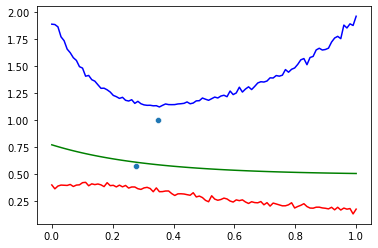

In [27]:
model_line = model(kilometers_line, params=jax.tree_map(jnp.mean, samples))
fig, ax = plt.subplots(figsize=(6, 4))
p1 = sns.scatterplot(x=kms, y=prices, ax=ax)
p2 = sns.lineplot(x=kilometers_line, y=model_line, color='g', ax=ax)
p2 = sns.lineplot(x=kilometers_line, y=upper_limit, color='b', ax=ax)
p2 = sns.lineplot(x=kilometers_line, y=lower_limit, color='r', ax=ax)

# Predicting for all car models

In [28]:
x = dt[dt["brand"] == "toyota"].set_index(["model", "model_observation_id"])[["norm_price", "norm_km", "price_max"]].to_xarray()
models = x.model
x["norm_price"]

<xarray.DataArray 'norm_price' (model: 18, model_observation_id: 2122)>
array([[0.63471503, 0.67357513, 0.77512953, ...,        nan,        nan,
               nan],
       [0.53046378, 0.75768415, 0.76980903, ...,        nan,        nan,
               nan],
       [0.61666667, 0.47333333, 0.43333333, ...,        nan,        nan,
               nan],
       ...,
       [0.12781328, 0.88885802, 0.62767435, ...,        nan,        nan,
               nan],
       [1.        , 0.63616869, 0.82844889, ...,        nan,        nan,
               nan],
       [0.53856511, 0.41354107, 0.44239277, ..., 0.3344874 , 0.27697634,
        0.54799   ]])
Coordinates:
  * model                 (model) object 'toyota Auris' ... 'toyota Yaris'
  * model_observation_id  (model_observation_id) int64 0 1 2 ... 2119 2120 2121

In [29]:
price_mask = (~x["norm_price"].isnull()).to_numpy()
price = x["norm_price"].fillna(0.0).astype("float32").to_numpy()
kms = x["norm_km"].fillna(0.0).astype("float32").to_numpy()

In [30]:
from numpyro.distributions import constraints
import jax
from jax import random
from jax import numpy as jnp

@jax.jit
def m_fun(values, speed, scale, base, offset):
    r = jnp.exp(-speed * (values + offset)) * scale + jnp.maximum(base, 0.0)
    return jnp.maximum(r, 0.0)

vectorized_model = jax.vmap(m_fun)

def model_bayes_all_cars(kilometers, prices=None, price_mask=None):
    with numpyro.plate("car_model", kilometers.shape[0]):
        base = numpyro.sample("base", dist.HalfCauchy(0.05))
        offset = numpyro.sample("offset", dist.Normal(0, 1))
        scale = numpyro.sample("scale", dist.Normal(1, 0.2))
        speed = numpyro.sample("speed", dist.HalfNormal(10))
        σ = numpyro.sample("error_std", dist.HalfNormal(0.1))

    result = numpyro.deterministic("pred_raw", vectorized_model(kilometers, speed, scale, base, offset))

    result_flat = result.reshape(-1)
    σ_flat = jnp.tile(jnp.array(σ).reshape(-1, 1), reps=kilometers.shape[1]).reshape(-1)
    if price_mask is not None:
        obs = prices.reshape(-1)
        with numpyro.handlers.mask(mask=price_mask.reshape(-1)):
            obs = numpyro.sample("observations", dist.Normal(result_flat, σ_flat), obs=obs)
    else:
        with numpyro.plate("independent_obs", kilometers.reshape(-1).shape[0]):
            numpyro.sample("observations", dist.Normal(result_flat, σ_flat))

    return result_flat

In [31]:
from numpyro.infer import Trace_ELBO, SVI
from numpyro.infer.autoguide import  AutoNormal, AutoLowRankMultivariateNormal

guide = AutoNormal(model_bayes_all_cars)
optimizer = numpyro.optim.Adam(step_size=0.001)
svi = SVI(model_bayes_all_cars, guide, optimizer, loss=Trace_ELBO())

svi_result = svi.run(random.PRNGKey(0), 200_000, kilometers=kms, prices=price, price_mask=price_mask)
params = svi_result.params

100%|██████████| 200000/200000 [02:14<00:00, 1490.33it/s, init loss: 30928164.0000, avg. loss [190001-200000]: -6903.8633]


In [32]:
all_ks_line = jnp.tile(jnp.linspace(0, 1, 30), (price.shape[0], 1))

post_samples = guide.sample_posterior(random.PRNGKey(0), svi_result.params, sample_shape=(2000,))
predictive = Predictive(model_bayes_all_cars, params=params, posterior_samples=post_samples, num_samples=2000)
samples = predictive(random.PRNGKey(1), kilometers=all_ks_line, prices=None, price_mask=None)
result_dist = samples["observations"].reshape(2000, price.shape[0], 30)


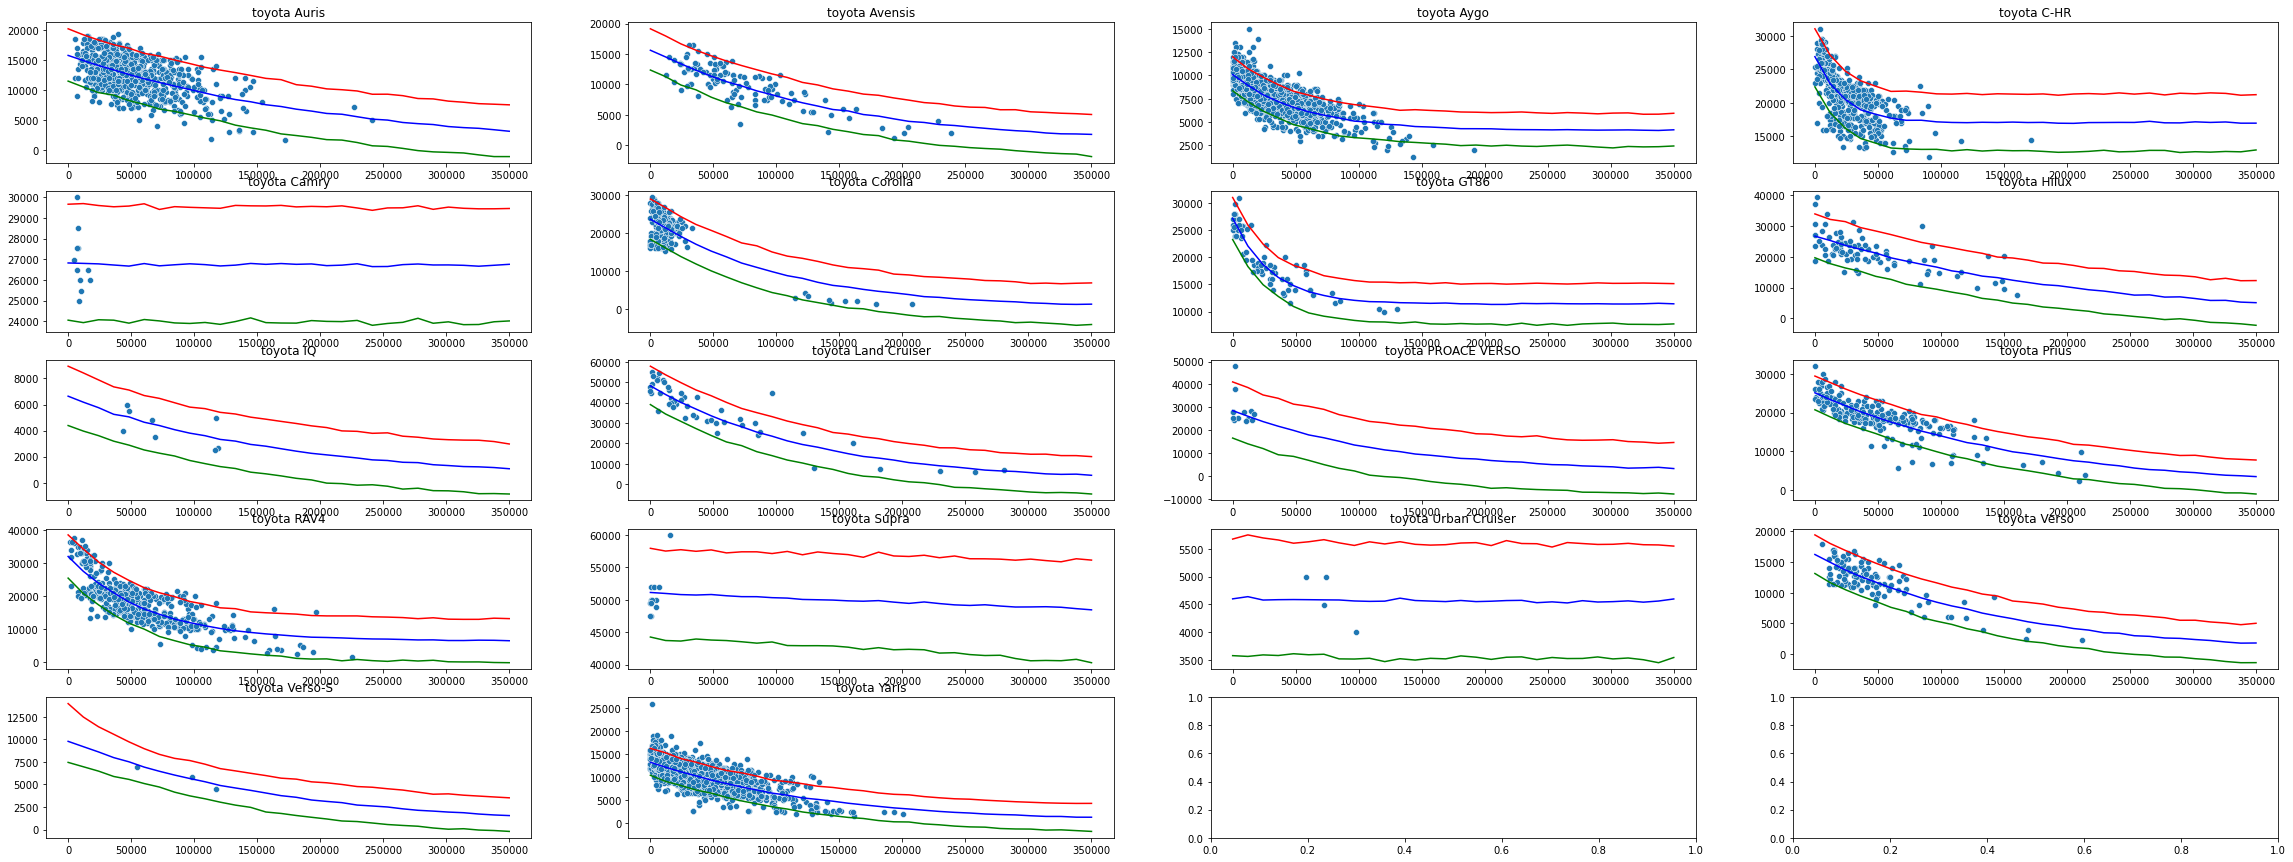

In [33]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(40, 15), ncols=4, nrows=(price.shape[0] + 2)//4)

def quantile(dist, q):
    return jax.vmap(lambda x: jnp.quantile(x, q), in_axes=0)(dist[:, n_to_plot, :].transpose())
    
for i in range(price.shape[0]):
    n_to_plot = i
    sub_plot = ax[i//4, i%4]
    sub_plot.set_title(models.to_numpy()[i])
    max_price_of_model = float(x["price_max"][n_to_plot, 0])
    
    p1 = sns.scatterplot(x=kms[n_to_plot][price_mask[n_to_plot]] * MAX_KILOMETERS,
                         y=price[n_to_plot][price_mask[n_to_plot]] * max_price_of_model, ax=sub_plot)
    p2 = sns.lineplot(x=all_ks_line[n_to_plot] * MAX_KILOMETERS, y=quantile(result_dist, 0.05) * max_price_of_model, color='g', ax=sub_plot)
    p2 = sns.lineplot(x=all_ks_line[n_to_plot] * MAX_KILOMETERS, y=quantile(result_dist, 0.5) * max_price_of_model, color='b', ax=sub_plot)
    p2 = sns.lineplot(x=all_ks_line[n_to_plot] * MAX_KILOMETERS, y=quantile(result_dist, 0.95) * max_price_of_model, color='r', ax=sub_plot)

# Hierarchical learning

In [34]:

@jax.jit
def m_fun(values, speed, scale, base, offset):
    base_p = jnp.maximum(base, 0.0)
    speed_p = jnp.maximum(speed, 0.0)
    return jnp.maximum(jnp.exp(-speed_p * (values + offset)) * base_p + base, 0.0)

vectorized_model = jax.vmap(m_fun)

def model_bayes_all_cars(kilometers, prices=None, price_mask=None):
    base = numpyro.sample("base", dist.HalfCauchy(0.05))
    offset = numpyro.sample("offset", dist.Normal(0, 1))
    scale = numpyro.sample("scale", dist.Normal(1, 0.2))
    speed = numpyro.sample("speed", dist.HalfNormal(10))


    base_std = numpyro.sample("base_std", dist.HalfNormal(0.1))
    offset_std = numpyro.sample("offset_std", dist.HalfNormal(0.1))
    scale_std = numpyro.sample("scale_std", dist.HalfNormal(0.1))
    speed_std = numpyro.sample("speed_std", dist.HalfNormal(1))

    with numpyro.plate("car_model", kilometers.shape[0]):
        base_final = numpyro.sample("base_final", dist.Normal(base, base_std))
        offset_final = numpyro.sample("offset_final", dist.Normal(offset, offset_std))
        scale_final = numpyro.sample("scale_final", dist.Normal(scale, scale_std))
        speed_final = numpyro.sample("speed_final", dist.Normal(speed, speed_std))
        σ = numpyro.sample("error", dist.HalfNormal(0.1))

    r = numpyro.deterministic("pred_raw", vectorized_model(kilometers, speed_final, scale_final, base_final, offset_final))

    r_flat = r.reshape(-1)
    σ_flat = jnp.tile(jnp.array(σ).reshape(-1, 1), reps=kilometers.shape[1]).reshape(-1)

    if price_mask is not None:
        obs = prices.reshape(-1)
        with numpyro.handlers.mask(mask=price_mask.reshape(-1)):
            obs = numpyro.sample("observations", dist.Normal(r_flat, σ_flat), obs=obs)
    else:
        with numpyro.plate("independent_obs", kilometers.reshape(-1).shape[0]):
            numpyro.sample("observations", dist.Normal(r_flat, σ_flat))

    return r

In [35]:
from numpyro.infer import Trace_ELBO, SVI
from numpyro.infer.autoguide import  AutoNormal

guide = AutoNormal(model_bayes_all_cars)
optimizer = numpyro.optim.Adam(step_size=0.001)
svi = SVI(model_bayes_all_cars, guide, optimizer, loss=Trace_ELBO())

svi_result = svi.run(random.PRNGKey(0), 200_000, kilometers=kms, prices=price, price_mask=price_mask)
params = svi_result.params

100%|██████████| 200000/200000 [01:53<00:00, 1759.52it/s, init loss: 23185.9512, avg. loss [190001-200000]: -6941.1274]


In [36]:
all_ks_line = jnp.tile(jnp.linspace(0, 1, 35), (price.shape[0], 1))

post_samples = guide.sample_posterior(random.PRNGKey(0), svi_result.params, sample_shape=(2000,))
predictive = Predictive(model_bayes_all_cars, params=params, posterior_samples=post_samples, num_samples=2000)
samples = predictive(random.PRNGKey(1), kilometers=all_ks_line, prices=None, price_mask=None)

In [37]:
result_dist = samples["observations"].reshape(2000, price.shape[0], 35)
result_dist.shape

(2000, 18, 35)

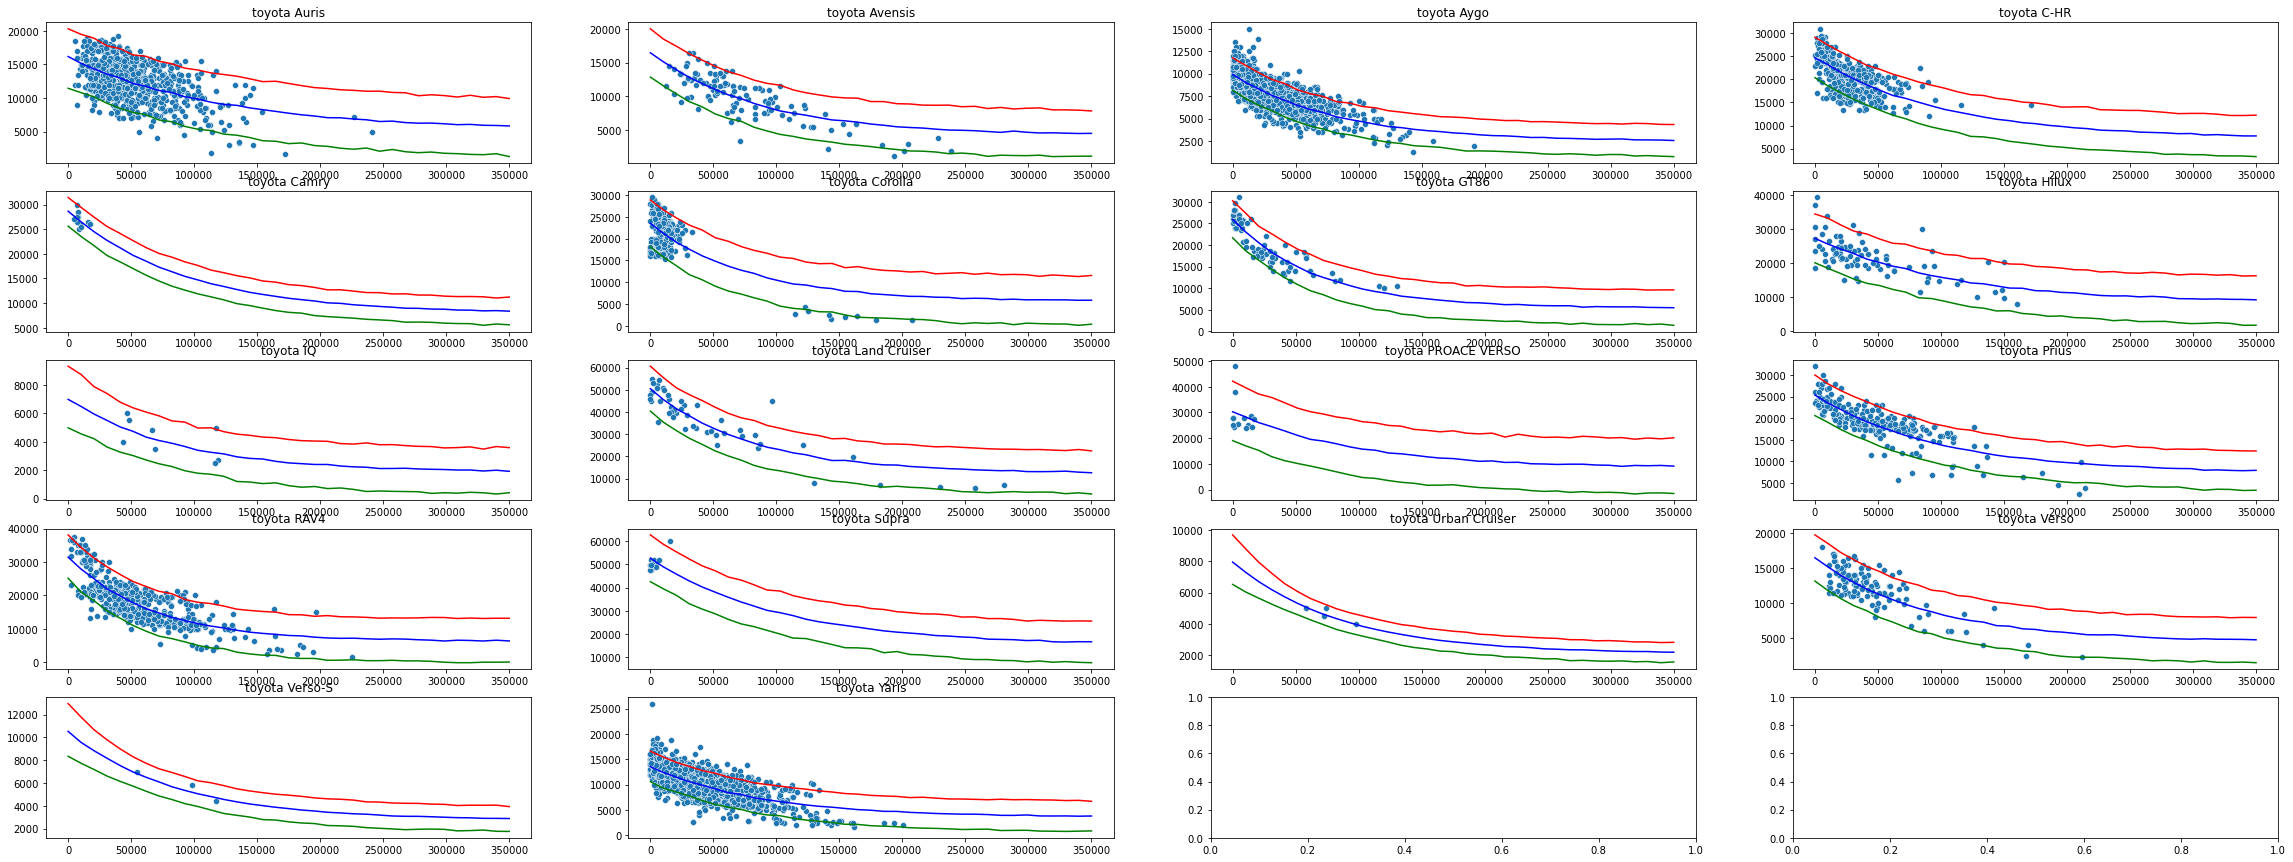

In [38]:
fig, ax = plt.subplots(figsize=(40, 15), ncols=4, nrows=(price.shape[0] + 2)//4)

def quantile(dist, q):
    return jax.vmap(lambda x: jnp.quantile(x, q), in_axes=0)(dist[:, n_to_plot, :].transpose())
    
for i in range(price.shape[0]):
    n_to_plot = i
    sub_plot = ax[i//4, i%4]
    sub_plot.set_title(models.to_numpy()[i])
    max_price_of_model = float(x["price_max"][n_to_plot, 0])
    
    p1 = sns.scatterplot(x=kms[n_to_plot][price_mask[n_to_plot]] * MAX_KILOMETERS,
                         y=price[n_to_plot][price_mask[n_to_plot]] * max_price_of_model, ax=sub_plot)
    p2 = sns.lineplot(x=all_ks_line[n_to_plot] * MAX_KILOMETERS, y=quantile(result_dist, 0.05) * max_price_of_model, color='g', ax=sub_plot)
    p2 = sns.lineplot(x=all_ks_line[n_to_plot] * MAX_KILOMETERS, y=quantile(result_dist, 0.5) * max_price_of_model, color='b', ax=sub_plot)
    p2 = sns.lineplot(x=all_ks_line[n_to_plot] * MAX_KILOMETERS, y=quantile(result_dist, 0.95) * max_price_of_model, color='r', ax=sub_plot)

In [45]:
for idx, model in enumerate(models.to_numpy()):
    max_price_of_model = float(x["price_max"][idx, 0])
    after_driving_50k = (result_dist[:, idx, 5:] - result_dist[:, idx, :-5]) * max_price_of_model
    bad = float((after_driving_50k < -1000).sum())
    good = float((after_driving_50k > -1000).sum())
    print(f"{model}: {bad/ (good + bad)}")

toyota Auris: 0.5392833333333333
toyota Avensis: 0.5613166666666667
toyota Aygo: 0.4755333333333333
toyota C-HR: 0.6145166666666667
toyota Camry: 0.67175
toyota Corolla: 0.5858833333333333
toyota GT86: 0.6093833333333334
toyota Hilux: 0.59045
toyota IQ: 0.40265
toyota Land Cruiser: 0.6468833333333334
toyota PROACE VERSO: 0.5815833333333333
toyota Prius: 0.61525
toyota RAV4: 0.60985
toyota Supra: 0.6735333333333333
toyota Urban Cruiser: 0.33058333333333334
toyota Verso: 0.56375
toyota Verso-S: 0.44455
toyota Yaris: 0.5371333333333334
